This notebook prepares the subject-level distances for Liu 2019 kept data

This is the second step of the processing

There is another step of processing (st16) before this one

### hla heterozygosity metrics for each subject

    depth on Zheng 2021 positive TCRs, set
    
    depth on Zheng 2021 positive TCRs, breadth

In [1]:
import pandas as pd
import numpy as np

import re

from collections import defaultdict
from collections import Counter

import matplotlib.pyplot as plt

In [2]:
# load the two predicted score files

result_dir = "../results/"

depth_file = "st4_HLA_I_zheng_2021_ensemble_reshape_20.csv"

df_depth = pd.read_csv(result_dir + depth_file, header = 0)

print(df_depth.shape)

(10008, 85)


In [3]:
# verify consistency between the columns of score files and the order in pseudo seq file
ori_data_dir = "../data/"
pseudo_file = "for_encoders/HLA_I_pseudo_40.csv"
df_pseudo = pd.read_csv(ori_data_dir + pseudo_file, header = 0)

In [4]:
Counter([a==b for a,b in zip(df_pseudo.hla.tolist(), df_depth.columns.tolist())])

Counter({True: 85})

In [5]:
# construct a dictionary of tcr index sets for HLAs
# use threshold 0.5

cutoff = 0.5

depth_hla_dict = defaultdict(set)

hla_85_list = df_depth.columns.tolist()

for hla in hla_85_list:
    hla_formatted = "".join(re.split('-|\*|:', hla)[1:])
    depth_cur_column = df_depth[hla].tolist()
    depth_hla_dict[hla_formatted] = set([i for i, x in enumerate(depth_cur_column) if x>=cutoff])

In [6]:
min([len(x) for x in depth_hla_dict.values()])

3368

In [7]:
max([len(x) for x in depth_hla_dict.values()])

6007

In [8]:
# define a function to compute the distance between two sets

def set_dist(a, b):
    de = len(a.union(b))
    nu = len(a-b) + len(b-a)
    return(nu/de)

In [9]:
# load the previously extended subject feature file to add v allele heterozygosity score 
# using set distance

feature_file = "st16_liu_2019_depth_aa_scores.csv"

df_liu_2019 = pd.read_csv(result_dir + feature_file, header=0)

In [10]:
# create a dictionary for the distance between any two hla i alleles from 
# the 85 under consideration
hla_i_85_format = ["".join(re.split('-|\*|:', x)[1:]) for x in df_depth.columns.tolist()]

# one dictionary based on associated TCRs from one resource
depth_dict = defaultdict(float)

for a in hla_i_85_format:
    cur_a_set = depth_hla_dict[a]
    for b in hla_i_85_format:
        cur_b_set = depth_hla_dict[b]
        depth_dict[(a, b)] = set_dist(cur_a_set, cur_b_set)

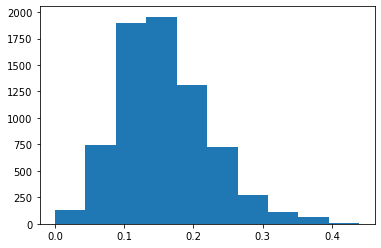

In [11]:
plt.hist(depth_dict.values())
plt.show()

In [12]:
plot_depth_dict_keys = list(depth_dict.keys())
plot_depth_dict_values = [depth_dict[x] for x in plot_depth_dict_keys]

In [13]:
df_liu_2019[:2]

,Unnamed: 0,total_muts,nonsyn_muts,clonal_muts,subclonal_muts,heterogeneity,total_neoantigens,CNA_prop,"gender (Male=1, Female=0)",biopsy site,...,biopsyContext (1=Pre-Ipi; 2=On-Ipi; 3=Pre-PD1; 4=On-PD1),daysBiopsyToPD1,daysBiopsyAfterIpiStart,purity,ploidy,hla_class_i_alleles,homozygous,hla_class_i_alleles_replace,depth_ave,aa_ave
0,Patient1,34,22,12,10,0.454545,49,0.321417,0,skin,...,3,-84,unk,0.92,1.73,"A0201,A1101,B1801,B4402,C0501,C1203",0,"A0201,A1101,B1801,B4402,C0501,C1203",0.024470,0.283245
1,Patient10,96,71,48,22,0.314286,230,0.391384,0,skin,...,3,-12,107,0.83,1.84,"A0101,A0201,B0801,B1501,C0304,C0701",0,"A0101,A0201,B0801,B1501,C0304,C0701",0.051861,0.343986


In [14]:
# compute the distance for each subject based on TCR sets


genotype_replace_list = [x.split(",") for x in df_liu_2019.hla_class_i_alleles_replace.tolist()]

set_depth_aa = []
set_depth_bb = []
set_depth_cc = []

for genotype in genotype_replace_list:
    set_depth_aa += [depth_dict[(genotype[0], genotype[1])]]
    set_depth_bb += [depth_dict[(genotype[2], genotype[3])]]   
    set_depth_cc += [depth_dict[(genotype[4], genotype[5])]]

set_depth_ave = [(x+y+z)/3 for x,y,z in zip(set_depth_aa, set_depth_bb, set_depth_cc)]

In [15]:
df_liu_2019["depth_set_ave"] = set_depth_ave

In [16]:
df_liu_2019.shape

(143, 52)

In [17]:
df_liu_2019.columns.tolist()

['Unnamed: 0',
 'total_muts',
 'nonsyn_muts',
 'clonal_muts',
 'subclonal_muts',
 'heterogeneity',
 'total_neoantigens',
 'CNA_prop',
 'gender (Male=1, Female=0)',
 'biopsy site',
 'monthsBiopsyPreTx',
 'BR',
 'PFS',
 'OS',
 'TimeToBR',
 'cyclesOnTherapy',
 'txOngoing',
 'Tx',
 'Mstage (IIIC=0, M1a=1, M1b=2, M1c=3)',
 'Tx_Start_ECOG',
 'Tx_Start_LDH',
 'LDH_Elevated',
 'Brain_Met',
 'Cut_SubQ_Met',
 'LN_Met',
 'Lung_Met',
 'Liver_Visc_Met',
 'Bone_Met',
 'progressed',
 'dead',
 'Primary_Type',
 'Histology',
 'IOTherapy',
 'steroidsGT10mgDaily',
 'priorMAPKTx',
 'priorCTLA4',
 'postCTLA4',
 'postMAPKTx',
 'postCombinedCTLA_PD1',
 'numPriorTherapies',
 'biopsy site_categ',
 'biopsyContext (1=Pre-Ipi; 2=On-Ipi; 3=Pre-PD1; 4=On-PD1)',
 'daysBiopsyToPD1',
 'daysBiopsyAfterIpiStart',
 'purity',
 'ploidy',
 'hla_class_i_alleles',
 'homozygous',
 'hla_class_i_alleles_replace',
 'depth_ave',
 'aa_ave',
 'depth_set_ave']

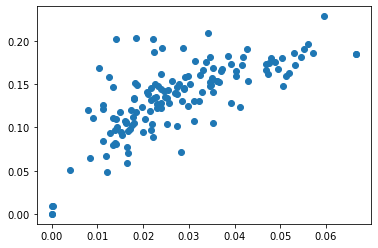

In [18]:
plt.scatter(df_liu_2019.depth_ave, df_liu_2019.depth_set_ave)
plt.show()

In [19]:
# compute hla breadth metric for each subject
# compute distances between subjects


# first, get list of sets with unioned set of TCRs as the set

depth_subject_list = []

for geno in genotype_replace_list:
    
    six_depth_sets = [depth_hla_dict[geno[0]], depth_hla_dict[geno[1]], 
                      depth_hla_dict[geno[2]], depth_hla_dict[geno[3]],
                      depth_hla_dict[geno[4]], depth_hla_dict[geno[5]]]
                    
    cur_depth_union = set().union(*six_depth_sets)
                    
    depth_subject_list += [cur_depth_union]
    
    
# second, get hla breadth for each subject

depth_breadth = [len(x) for x in depth_subject_list]
    
df_liu_2019["depth_breadth"] = depth_breadth
    
    
# third, compute the set distances

set_depth_mat = []

for a in depth_subject_list:
    cur_depth_row = []
    for b in depth_subject_list:
        cur_depth_row += [set_dist(a, b)]
    set_depth_mat += [cur_depth_row]

In [20]:
# save the extended df_liu_2019 file out
df_liu_2019.to_csv("../results/st17_liu_2019_depth_aa_set_breadth.csv", 
                   index = False)